# Régression et extrapolation

Contrairement au problème d'interpolation qui consiste à passer par un ensemble de points donnés, les problèmes de régression ou d'extrapolation ne supposent pas de passer par l'ensemble de ces points. Il s'agit plutôt de trouver une _meilleure_ représentation de l'ensemble de ces points, de façon plus économe (on parle alors de compression) ou plus symmétrique (on parle alors de lissage).

In [1]:
from typing import List, Tuple
from matplotlib import pyplot as plt

## Régression

## Courbes de Bézier

Les [courbes de Bézier](https://fr.wikipedia.org/wiki/Courbe_de_B%C3%A9zier) consiste à encadrer une courbe par un petit nombre de points, et de faire en sorte que cette courbe soit unique et lisse. Elles servent abondament dans les contextes du dessin industriel (où elles ont été inventées) et de la représentation des graphiques par ordinateur (jeux vidéo, police de caractères, logiciel de retouche d'image, ... ) puisqu'elles sont à la base de ce que l'on appelle le [dessin vectoriel](https://fr.wikipedia.org/wiki/Image_vectorielle).

La formule générale d'écriture d'une courbe de Bézier à deux dimensions (dans le plan $\left(x,y\right)$ donc) s'écrit

$$
\mathbf{B}\left(t\right) = \sum_{i=0}^n {n\choose i}(1 - t)^{n - i}t^i\mathbf{P}_i
$$

où 

 - le paramètre $t$ varie sur l'intervale $\left[0,1\right]$ uniquement,
 - les coefficients ${n \choose i} = \frac{n!}{i!(n - i)!}$ sont les [coefficients binomiaux](https://fr.wikipedia.org/wiki/Coefficient_binomial)
 - les $\mathbf{P}_i$ sont les points dit **de contrôle** de la courbe de Bézier, il s'écrivent $\mathbf{P}_i = \left(x_{i}, y_{i}\right)$. Il y a $n$ points de contrôle pour une courbe d'ordre $n$. 

L'écriture ci-dessus est vectorielle, puisqu'elle représente un parcours en deux dimensions, c'est-à-dire une courbe paramétrique, dont le paramètre est $t$. On peut réécrire cette courbe sous la forme vectorielle explicite $\mathbf{B}\left(t\right)=\left(B_{x}\left(t\right), B_{y}\left(t\right)\right)$, et on aura donc 

\begin{align}
B_{x}\left(t\right) &= \sum_{i=0}^n {n\choose i}(1 - t)^{n - i}t^i x_i \\
B_{y}\left(t\right) &= \sum_{i=0}^n {n\choose i}(1 - t)^{n - i}t^i y_i
\end{align}

```{admonition} Polynôme de Bernstein
:class: hint

La courbe de Bézier peut s'écrire encore

$$
\mathbf{B}\left(t\right) = \sum_{i=0}^n b_{n,i}\left(t\right)\mathbf{P}_i \;,\; b_{n,i} = {n\choose i}(1 - t)^{n - i}t^i
$$

où les $b_{n,i}$ sont les [polynômes de Bernstein](https://fr.wikipedia.org/wiki/Polyn%C3%B4me_de_Bernstein) de degrés $n$.
```

Parmis les propriétés importantes des courbes de Bézier, remarquons que

 - en $t=0$, on a $\mathbf{B}\left(t=0\right)=\mathbf{P}_{0}$, la courbe de Bézier passe par le premier point
 - en $t=1$, on a $\mathbf{B}\left(t=1\right)=\mathbf{P}_{n}$, la courbe de Bézier passe par le dernier point
 
Et pendant son tracé, de $t=0$ à $t=1$, la courbe paramétrique de Bézier ne va plus en général passer par un autre point $\mathbf{P}_{i}$, sauf cas particulier.

### Algorithme deCasteljau de calcul des courbes de Bézier

Du fait de la condition de récurence

$$
{n \choose k} + {n \choose k+1} = {n+1 \choose k+1}
$$

des coefficients binomiaux, on peut écrire les courbes de Bézier à l'aide de l'[algorithme de deCasteljau](https://fr.wikipedia.org/wiki/Algorithme_de_Casteljau), qui permet de résoudre les problèmes d'instabilité numérique liés à l'évaluation des sommes de polynômes de Bernstein.

Cet algorithme utilise la représentation 

$$
\mathbf{B}\left(t\right) = \sum_{i=0}^n b_{n,i}\left(t\right)\mathbf{P}_i \;,\; b_{n,i} = {n\choose i}(1 - t)^{n - i}t^i
$$

pour lequel on remplit un tableau $\beta$ correspondant aux tuples de points de contrôle, et on modifie les valeurs de ce tableau autant de fois qu'il y a de points de contrôle. Ainsi, le tableau est instancié sous la forme

$$\beta^{(0)} = \left[\left(x_{0}, y_{0}\right), \left(x_{1}, y_{1}\right), \ldots, \left(x_{i}, y_{i}\right), \ldots \right],\ \ i=0,\ldots,n$$

puis à chaque étape on réduit les éléments modifiés sous la forme

$$\beta_i^{(j)} = \beta_i^{(j-1)} (1-t_0) + \beta_{i+1}^{(j-1)} t_0,\ \ i = 0,\ldots,n-j,\ \ j= 1,\ldots,n$$

et à la fin on aura la valeur de la courbe de Bézier au point $t_{0}$ à la place du premier coefficient du tableau, après $n$ itérations

$$\mathbf{B}(t_0) = \beta_0^{(n)}$$

les autres coefficients ne servant plus à rien.

In [2]:
def deCasteljau(t: float, coefs: List[Tuple[float, float]]) -> Tuple[float, float]:
    """Evaluate the Bézier curve at point t, using deCasteljau's algorithm."""
    # values in this list are overridden
    beta = [(x,y) for x, y in coefs] 
    for j in range(1, len(coefs)):
        for k in range(len(coefs) - j):
            beta[k] = (beta[k][0] * (1 - t) + beta[k + 1][0] * t, 
                       beta[k][1] * (1 - t) + beta[k + 1][1] * t)
    return beta[0]

### Représentation en classe des courbes de Bézier

On représente les courbes de Bézier paramétrées par un ensemble de points sous la forme usuelle du `__init__` qui prend en charge les paramètres de la courbes (ici les points `(x,y)` donnés sous forme de tuples) et la méthode `__call__` qui prend en charge l'évaluation (au point `0 <= t <= 1`) de la courbe de Bézier. Cette dernière méthode renvoi le tuple `(x,y)` représentant la position dans le plan de la courbe de Bézier.

In [3]:
def C(n: int, k: int):
    """Calculate the C(n,k) binomial combination coefficient."""
    if n < 2*k: 
        if n < k:
            raise ValueError("n must be larger than k")
        return C(n, n-k)
    res, denom = 1, 1
    for m in range(n-k+1, n+1):
        res = (res * m) // denom
        denom += 1
    return res

In [4]:
class BézierCurve():
    """Given a set of control points, one can plot a curve developped on the Bernstein polynomials, 
    called a Bézier curve. The control points (x,y) are given in the form of 2D-tuple. 
    They represent point in the plane, and construct a curve in 2D.
    """
    
    def __init__(self, points):
        if any(len(point) != 2 for point in points):
            raise ValueError("all Ps must be a tuple of same length")
        self.n = len(points) - 1
        self.points = list(points)
        return None
    
    def _check_t(self, t):
        if not 0 <= t <= 1:
            raise ValueError("t must be in [0,1] interval")
        return None
    
    def __call__(self, t: float) -> Tuple[float, float]:
        """Evaluate the Bézier curve at point t using brute force algorithm."""
        self._check_t(t)
        n = self.n
        x = sum(C(n,i)*(1-t)**(n-i)*t**i*self.points[i][0] for i in range(n+1))
        y = sum(C(n,i)*(1-t)**(n-i)*t**i*self.points[i][1] for i in range(n+1))
        return x, y

```{admonition} Algorithme de deCasteljau
:class: example
On peut préférer utiliser l'algorithme de deCasteljau pour évaluer la valeur de la courbe de Bézier au point correspondant plutôt qu'un algorithme de brute force comme ci-dessus.
```

On trace/modifie alors les courbes de Béziers en déplaçant les points de contrôles.

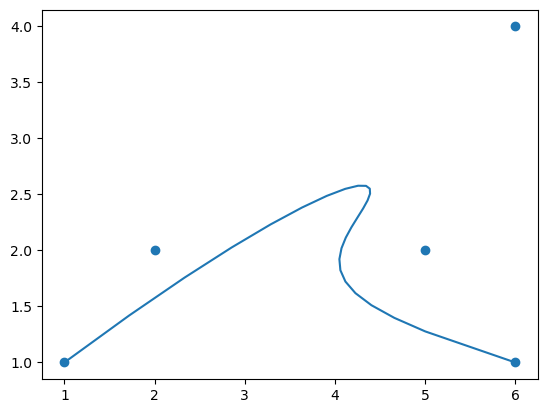

In [5]:
P = [(1,1), (6, 4), (5,2), (2, 2), (6,1)]

bc = BézierCurve(P)

# nb points de la courbe de Bézier
n = 25
t = [i/(n+1) for i in range(n)] + [1]

b = [bc(_) for _ in t]

plt.scatter([_[0] for _ in P], [_[1] for _ in P])
plt.plot([_[0] for _ in b], [_[1] for _ in b])
plt.show()

À part les points initiaux et finaux, la courbe de Bézier ne passe pas nécessairement par les points de contrôle.

### Surface de Bézier

Les surfaces de Bézier sont une généralisation des courbes de Bézier, à trois dimensions. Elles utilisent des points de contrôles à trois dimensions $\left(x,y,z\right)$ et leur formule s'écrit

$$
\mathbf{B}\left(t\right) = \sum_{i=0}^{n} \sum_{j=0}^{m} b_{n,i}\left(u\right) b_{m,j}\left(v\right) \mathbf{P}_{i,j} \;,\; b_{n,i} \left(t\right) = {n\choose i}(1 - t)^{n - i}t^i
$$

où il y a $n\times m$ points de contrôles $\mathbf{P}_{i,j} $ répartis sur une grille représentant les coordonnées $x$ et $y$, tandis que l'altitude $z$ donne la troisième dimension du point de contrôle. Il n'y a pas d'ordre dans l'arrangement des points en $x$ _et en_ $y$ : ces deux dimensions sont dissociées, et on parle de produit tensoriel d'espace dans ce cas. En revanche, l'ordre des points de passage en $x$ _ou_ en $y$ est déterminé.

![Surface de Bézier](fig/bezsurf.gif)